In [1]:
# ----- LIBS

# geoprocessamento
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping

# plots
import matplotlib.pyplot as plt

# Roteiro

- Acessando dataset ARCGIS (Mapa de Edificações)
- ADD prédio Funcamp
- ADD coluna de centroids
- Salvando dataset no crs SIRGAS 2000 / UTM zone 23S
- Salvando dataset no crs WGS 84

## Acessando dataset ARCGIS (Mapa de Edificações)

- Baseado em: https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

In [2]:
# ----- Apontando para o path do dataset do Mapa de Edificações 
import os

current_path = os.getcwd()
# print(current_path)
# print(current_path.find('obstacle_exp'))

map_dataset_path = current_path[0:current_path.find('obstacle_exp')]
building_shp_path = "datasets/unicamp-arcgis-dataset/edificacoes.shp"
unicamp_building_dataset_path = map_dataset_path + building_shp_path

In [3]:
# ----- LENDO DATASET

unicamp_df = gpd.read_file(unicamp_building_dataset_path)
print('SHAPE:', unicamp_df.shape)
unicamp_df.head(2)

SHAPE: (1170, 8)


,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((287762.773 7475309.137 0.000, 2877..."
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((288123.323 7474311.958 0.000, 2881..."


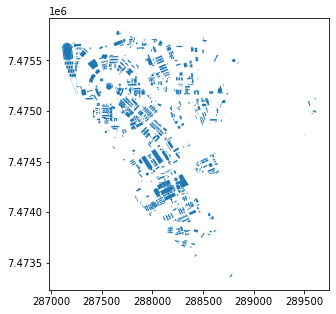

In [4]:
# ----- PLOT DO MAPA DE EDIFICAÇÕES
ax = unicamp_df.plot(figsize=(12, 5))

In [5]:
# ----- CHECK DE CRS
unicamp_df.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 48°W to 42°W
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# ----- CHECK DE TYPE
unicamp_df.dtypes

Id             float64
PREDIO         float64
NOME_DO_PR      object
UNIDADE         object
GlobalID        object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

In [7]:
# ----- POLYGON Z TO POLYGON

# Study - POLYGON Z TO POLYGON
# test_row = unicamp_df.iloc[0:1]
# poly = get_polygon_coords(test_row)
# # print(poly)

# new_polygon = Polygon(poly[0])
# print(new_polygon)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
#         else:
#             print(p)
    return new_geo

# unicamp_df = gpd.GeoDataFrame.from_file(unicamp_building_dataset_path) # plug_in your shapefile
# geodf_2d = convert_3D_2D(unicamp_df.geometry) # new geodf with 2D geometry series
# geodf_2d.append(building_funcamp)
# unicamp_df['geometry'] = geodf_2d

## ADD prédio FUNCAMP 

In [8]:
# ----- FUNÇÕES ÚTEIS P/ MANIPULAÇÃO DE SHAPES

def get_polygon_coords (polygon):
    g = [i for i in polygon.geometry]
    x,y = g[0].exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    
    return coords

def create_box_building(building_name, bounds, offset_xmin, offset_ymin, offset_xmax, offset_ymax):
    new_building = box(
        bounds[0] - offset_xmin,
        bounds[1] - offset_ymin,
        bounds[2] -offset_xmax,
        bounds[3] -offset_ymax
    )

    print("Bounds do prédio " + str(building_name) + ":", bounds)
    print("\nÁrea:", new_building.area)
    print("Length:", new_building.length)
    
    return new_building


def compare_buildings(ref_building, new_building):
    geodataset_ref = gpd.GeoSeries(ref_building)
    ax = geodataset_ref.plot(color='Gray')

    geodataset_new = gpd.GeoSeries(new_building)
    geodataset_new.plot(ax=ax) 

    
def calculate_distance(ref_polygon, new_polygon):
    points_df = gpd.GeoDataFrame(columns=["geometry"])
    points_df.loc[:, 'geometry'] = ref_polygon
    points_df.loc[0, 'geometry'] = new_polygon

    points_df['centroid'] = points_df["geometry"].centroid

    # Cálculo de Distância entre Circle centroids e cada linha do dataset
    print("Distancia entre centroids:\n", points_df.distance(new_polygon.centroid))

    return points_df


def add_dataset_rows(geodataset, name, unit, length, area, geometry):
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'Id'] = -1000
    geodataset.loc[last_index, 'PREDIO'] = -1000
    geodataset.loc[last_index, 'NOME_DO_PR'] = name
    geodataset.loc[last_index, 'UNIDADE'] = unit
    geodataset.loc[last_index, 'GlobalID'] = '{aaa}'
    geodataset.loc[last_index, 'Shape_Leng'] = length
    geodataset.loc[last_index, 'Shape_Area'] = area
    geodataset.loc[last_index, 'geometry'] = geometry
    
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]


In [9]:
# Prédio de Referência: COMVEST
ref_id = 536 # index da linha do prédio COMVEST
ref_polygon = unicamp_df.iloc[ref_id:ref_id + 1] # ex Comvest 536-537
# get_polygon_coords(ref_polygon)

Bounds do prédio FUNCAMP: [287780.44710000046, 7475720.6586, 287803.73330000043, 7475736.4226]

Área: 260.70115679071546
Length: 67.89959999918938


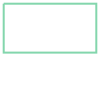

In [10]:
bounds_ref = list(ref_polygon.geometry.total_bounds)
building_funcamp = create_box_building("FUNCAMP", bounds_ref, -110, -107, -64.5, -79.5)
building_funcamp.boundary

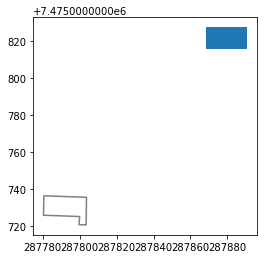

In [11]:
compare_buildings(ref_polygon['geometry'].boundary, building_funcamp )

In [12]:
# CALCULA DISTANCIA ENTRE CENTROIDS
calculate_distance(ref_polygon['geometry'], building_funcamp)
# ref_polygon

Distancia entre centroids:
 536    114.639238
0        0.000000
dtype: float64


,geometry,centroid
536,"POLYGON Z ((287803.733 7475735.618 0.000, 2878...",POINT (287792.711 7475730.255)
0,"POLYGON ((287868.233 7475827.659, 287868.233 7...",POINT (287879.340 7475821.791)


In [13]:
# add_node_dataset_rows(geodataset, name, unit, length, area, geometry)
add_dataset_rows(unicamp_df, 'FUNCAMP','FUNCAMP', 67.9, 260.70,  building_funcamp)

Novo Shape: (1171, 8)


,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry
1170,-1000.0,-1000.0,FUNCAMP,FUNCAMP,{aaa},67.9,260.7,"POLYGON ((287868.233 7475827.659, 287868.233 7..."


# ADD coluna de centroids

In [14]:
# ----- ADD COLUNA COM CENTROIDS

unicamp_df['centroid'] = unicamp_df.centroid
# unicamp_df['centroids']
unicamp_df.head(2)

,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry,centroid
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((287762.773 7475309.137 0.000, 2877...",POINT (287754.847 7475304.757)
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((288123.323 7474311.958 0.000, 2881...",POINT (288127.015 7474321.129)


QTDE DE CENTROIDS: (1171, 9)


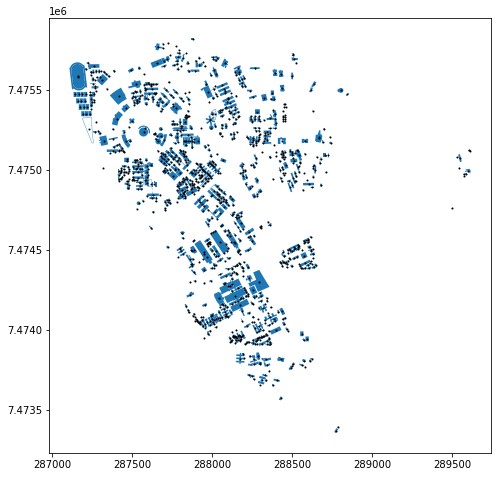

In [15]:
# ----- Plot UNICAMP MAPA Edificações COM CENTROIDS
ax = unicamp_df.plot(figsize=(17, 8))
print('QTDE DE CENTROIDS:',unicamp_df.shape )
unicamp_df['centroid'].plot(ax=ax,color='black',  markersize =1)
plt.savefig('mapa_unicamp_edificios_e_centroids.png',bbox_inches='tight')

In [16]:
unicamp_df.iloc[1170:1171]

,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry,centroid
1170,-1000.0,-1000.0,FUNCAMP,FUNCAMP,{aaa},67.9,260.7,"POLYGON ((287868.233 7475827.659, 287868.233 7...",POINT (287879.340 7475821.791)


## Salvando dataset no crs SIRGAS 2000 / UTM zone 23S 

In [17]:
# repos centroid colunm
unicamp_df_aux = unicamp_df.copy()
first_column = unicamp_df_aux.pop('centroid')
unicamp_df_aux.insert(7, 'centroid', first_column)

In [18]:
# converte p coluna de centroids p/ str
# caso contrario: 
# TypeError: Cannot interpret '<geopandas.array.GeometryDtype object at 0x7f24e3efe460>' as a data type
unicamp_df_aux['centroid'] = unicamp_df_aux['centroid'].astype(str) 

In [19]:
# SALVANDO MAPA NORMALIZADO DE PRÉDIOS no formato Shapefile
shapefile_name = 'unicamp_edificios_sirgas2000'
unicamp_df_aux.to_file(shapefile_name, driver = 'ESRI Shapefile')

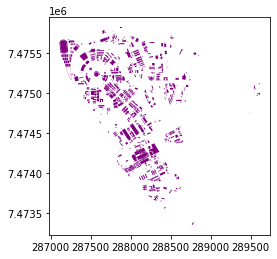

In [20]:
# Testando abrir arquivo salvo
unicamp_gdf = gpd.read_file(shapefile_name)
ax = unicamp_gdf['geometry'].plot(figsize=(12, 4), color='purple')

# Salvando dataset no crs WGS 84

In [17]:
unicamp_df = unicamp_df.to_crs(4326)
unicamp_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
unicamp_df.head(3)

,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry,centroid
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((-47.06788 -22.81649 0.00000, -47.0...",POINT (287754.847 7475304.757)
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((-47.06450 -22.82554 0.00000, -47.0...",POINT (288127.015 7474321.129)
2,1282.0,4.0,SALAS DE AULA,"FAC.ENGa.CIVIL,ARQ. E URBANISMO",{D8A7EC89-2748-4E88-A3EB-6F9F1936A78E},176.558770,789.413458,"POLYGON Z ((-47.06180 -22.81640 0.00000, -47.0...",POINT (288365.495 7475324.101)


In [18]:
# Centroids meters TO WSG84
unicamp_df['centroid'] = unicamp_df.centroid.to_crs(unicamp_df.crs)
unicamp_df.head(2)

<ipython-input-18-6dea06d5e5ed>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  unicamp_df['centroid'] = unicamp_df.centroid.to_crs(unicamp_df.crs)


,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry,centroid
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((-47.06788 -22.81649 0.00000, -47.0...",POINT (-47.06796 -22.81653)
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((-47.06450 -22.82554 0.00000, -47.0...",POINT (-47.06447 -22.82545)


QTDE DE CENTROIDS: (1171, 9)


<AxesSubplot:>

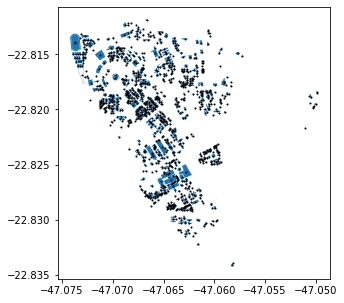

In [19]:
# ----- Plot UNICAMP MAPA Edificações COM CENTROIDS
ax = unicamp_df.plot(figsize=(12, 5))
print('QTDE DE CENTROIDS:',unicamp_df.shape )
unicamp_df['centroid'].plot(ax=ax,color='black',  markersize =1)

In [20]:
# repos centroid colunm
unicamp_df_aux = unicamp_df.copy()
first_column = unicamp_df_aux.pop('centroid')
unicamp_df_aux.insert(7, 'centroid', first_column)

In [21]:
# converte p coluna de centroids p/ str
# caso contrario: 
# TypeError: Cannot interpret '<geopandas.array.GeometryDtype object at 0x7f24e3efe460>' as a data type
unicamp_df_aux['centroid'] = unicamp_df_aux['centroid'].astype(str) 

In [22]:
# SALVANDO MAPA NORMALIZADO DE PRÉDIOS no formato Shapefile
shapefile_name = 'unicamp_edificios_wgs84'
unicamp_df_aux.to_file(shapefile_name, driver = 'ESRI Shapefile')

# Testando abrir arquivo salvo
# unicamp_gdf = gpd.read_file('elevação/' + shapefile_name + '.shp')

In [2]:
# Testando abrir arquivo salvo
shapefile_name = 'unicamp_edificios_wgs84'
unicamp_gdf = gpd.read_file(shapefile_name)

print('shape:', unicamp_gdf.shape)
unicamp_gdf.head()

shape: (1171, 9)


,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,centroid,geometry
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,POINT (-47.06795672687522 -22.81652622484874),"POLYGON Z ((-47.06788 -22.81649 0.00000, -47.0..."
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,POINT (-47.06446633687482 -22.82545318443932),"POLYGON Z ((-47.06450 -22.82554 0.00000, -47.0..."
2,1282.0,4.0,SALAS DE AULA,"FAC.ENGa.CIVIL,ARQ. E URBANISMO",{D8A7EC89-2748-4E88-A3EB-6F9F1936A78E},176.558770,789.413458,POINT (-47.06200737084524 -22.81642866763006),"POLYGON Z ((-47.06180 -22.81640 0.00000, -47.0..."
3,1213.0,3.0,"ENSINO NÃO FORMAL I -SALAS DE AULA, SANITÁRIOS...",REITORIA-DGRH-PRODECAD(PROGRAMA DE INTEGRAÇÃO ...,{3D213FFB-8861-4FCA-87C9-A345CC05A47F},146.166513,742.639919,POINT (-47.06196103350754 -22.82776994105871),"POLYGON Z ((-47.06173 -22.82776 0.00000, -47.0..."
4,1212.0,2.0,CRECHE-ÁREA DE SAÚDE,REITORIA-DGRH,{D8264B17-8B9E-4391-BDF7-77A0C6E2A0F5},277.043596,1226.905874,POINT (-47.06218980463417 -22.82763003696435),"POLYGON Z ((-47.06178 -22.82756 0.00000, -47.0..."


In [3]:
unicamp_gdf.iloc[702:703]

,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,centroid,geometry
702,1366.0,1.0,PRAÇA DO TEMPO E ESPAÇO - MUSEU EXPLORATÓRIO D...,REITORIA,{39F0163C-CAA8-41C1-BA5A-49B557D28EF6},114.182708,847.258674,POINT (-47.05771356138921 -22.81491411858421),"POLYGON Z ((-47.05754 -22.81492 0.00000, -47.0..."


In [4]:
# Elevacao museu
import requests
receive = requests.get('https://api.opentopodata.org/v1/aster30m?locations=-22.81491411858421,-47.05771356138921')

data = receive.json()

print(data)
print(data['results'][0])
print(data['results'][0]['elevation'])

{'results': [{'dataset': 'aster30m', 'elevation': 652.0, 'location': {'lat': -22.81491411858421, 'lng': -47.05771356138921}}], 'status': 'OK'}
{'dataset': 'aster30m', 'elevation': 652.0, 'location': {'lat': -22.81491411858421, 'lng': -47.05771356138921}}
652.0
